# Los Calculos más nuevos para el Articulo de CSDCM

Primero, vamos a intentarlo con un experimento que tenga una actividad notoria. Aquí cargamos un archivo que contiene los datos de un experimento con actividad epiléptica. La región CA aparece muy activa varias veces en las mediciones del potencial de campo local, LFP de ahora en adelante.

In [1]:
using PyPlot
using JLD

In [2]:
muacamuaca=open("../Actividad4AP/DatosActividadEpilepticaSelectos.bin", "r")
formaarray=(64,64,5001)
DatosExperimentales=read(muacamuaca, Float64, formaarray);
close(muacamuaca)

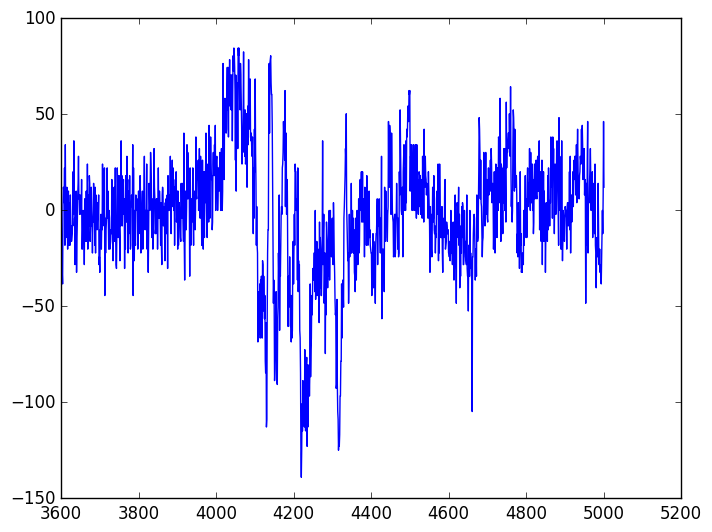

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fe592e5fe10>

In [3]:
#No todos los datos son interesantes
ion()
intervalo=3600:5001
plot(intervalo, vec(DatosExperimentales[52,40,intervalo]))

Por consistencia, vamos a transponer todos los datos para que las imagenes coincidan con las de Franco

In [4]:
#Primero Matamos los canales saturados
DatosExperimentales=DatosExperimentales[:,:,intervalo];
(alto,ancho,tmax)=size(DatosExperimentales)
map!(x-> abs(x)>1750? 0: x, DatosExperimentales);


In [5]:
for t=1:tmax
    DatosExperimentales[:,:,t]=transpose(DatosExperimentales[:,:,t])
end

In [6]:
save("DatosLFP4APusadosPaper.jld", "LFP", DatosExperimentales)

In [7]:
function UnNormGauss(x,sigma)
    return exp(-x*x/(2*sigma))
end

function GaussSuavizarTemporal(Datos,Sigma=3)  
    #sigma esta medido en pixeles, es la desviacion estandar de nuestro kernel.
    #El medioancho de nuestra ventana seran 3*sigma
    medioancho=ceil(Sigma*3)
    colchon=ones(medioancho)
    result=zeros(Datos)
    datoscolchon=vcat(colchon*Datos[1], Datos, colchon*Datos[end])
    kernel=map(x->UnNormGauss(x,Sigma), collect(-medioancho:medioancho))
    kernel=kernel/(sum(kernel))
    #La convolucion asi normalizada preserva el valor RELATIVO entre los puntos de la funcion.
    #pero queremos ponerlo mas parecido a los voltajes que medimos, para preservar el rango de valores
    #experimentales y su criterio de potenciales de accion / ruido
    for t=medioancho+1:length(Datos)+medioancho
        result[t-medioancho]=sum(datoscolchon[t-medioancho:t+medioancho].*kernel)
    end
    a=maximum(abs(Datos))
    b=maximum(abs(result))
    #nromalizacion 
    #result=result*a/b
    return result
end
    
#De momento todo "in file"
GaussianKernel=[0.00000067	0.00002292	0.00019117	0.00038771	0.00019117	0.00002292	0.00000067
0.00002292	0.00078634	0.00655965	0.01330373	0.00655965	0.00078633	0.00002292
0.00019117	0.00655965	0.05472157	0.11098164	0.05472157	0.00655965	0.00019117
0.00038771	0.01330373	0.11098164	0.22508352	0.11098164	0.01330373	0.00038771
0.00019117	0.00655965	0.05472157	0.11098164	0.05472157	0.00655965	0.00019117
0.00002292	0.00078633	0.00655965	0.01330373	0.00655965	0.00078633	0.00002292
    0.00000067	0.00002292	0.00019117	0.00038771	0.00019117	0.00002292	0.00000067]

function GaussianSmooth(Datos)
    tamanodatos=size(Datos)
    result=zeros(Datos)
    temp=copy(Datos)
    #Primero, hacemos el padding de los datos para que no se suavice demasiado
    for j=1:3
        temp=vcat(temp[1,:], temp, temp[end,:])
    end
    for j=1:3
        temp=hcat(temp[:,1], temp, temp[:,1])
    end
    
    for j=4:tamanodatos[1]+3, k=4:tamanodatos[2]+3
        #los indices van primero, "renglones", luego "columnas", etc
        aux=temp[j-3:j+3,k-3:k+3]
        result[j-3,k-3]=sum(GaussianKernel.*aux)
    end
    #Esta convolución no respeta norma L2
    #result=result*maximum(abs(Datos))/maximum(abs(result))
    return result
end

GaussianSmooth (generic function with 1 method)

In [8]:
function DropPeques(data)
    #solo funciona con data de dos indices.
    renglones,colus=size(data)
    prom=mean(abs(data[3]))
    result=zeros(1,colus)
    for k=1:renglones
        if abs(data[k,3])>prom
            result=vcat(result,data[k,:])
        end
    end
    return result
end

DropPeques (generic function with 1 method)

In [9]:
LaplacianTerm1=[[0 1 0]; [1 -4 1]; [0 1 0]]
LaplacianTerm2=[[0.5 0 0.5]; [0 -2 0]; [0.5 0 0.5]]
LaplacianKernel=(1-1/3)*LaplacianTerm1+(1/3)*LaplacianTerm2

function DiscreteLaplacian(Datos)
    result=zeros(Datos)
    temp=copy(Datos)
    #Primero, hacemos el padding de los datos para que no se suavice demasiado
    temp=vcat(temp[1,:], temp, temp[end,:])
    temp=hcat(temp[:,1], temp, temp[:,end])
    largo,ancho=size(Datos)
    aux=Array(Float64,(3,3))
    result=zeros(Datos)
    for j=2:largo+1, k=2:ancho+1
        #los indices van primero, "renglones", luego "columnas", etc
        aux=temp[j-1:j+1,k-1:k+1]
        result[j-1,k-1]=sum(LaplacianKernel.*aux)
    end
    return result
end

DiscreteLaplacian (generic function with 1 method)

In [10]:
aux=zeros(DatosExperimentales)
CSD=zeros(DatosExperimentales)
for t=1:tmax
    aux[:,:,t]=GaussianSmooth(DatosExperimentales[:,:,t])
    CSD[:,:,t]=-DiscreteLaplacian(aux[:,:,t])
end

Planchada quiere decir TEMPORALMENTE planchada, no espacialmente

In [11]:
CSDPlanchada=zeros(CSD)
(mu,nu,lu)=size(CSD)
for j=1:mu,l=1:nu
    porromponpon=vec(CSD[j,l,:])
    CSDPlanchada[j,l,:]=GaussSuavizarTemporal(porromponpon)
end

In [12]:
save("CSD4APForPaperTotal.jld", "CSD", CSD, "CSDPlanchada", CSDPlanchada)

In [13]:
function vecindad8(punto::Array)
    j=punto[1]
    k=punto[2]
    result=Set{Array{Int64,1}}()
    push!(result, [j-1,k-1])
    push!(result, [j-1,k])
    push!(result, [j-1,k+1])
    push!(result, [j,k-1])
    push!(result, [j,k+1])
    push!(result, [j+1,k-1])
    push!(result, [j+1,k])
    push!(result, [j+1,k+1])
    return result
end

function DropPeques(data)
    #solo funciona con data de dos indices.
    renglones,colus=size(data)
    prom=mean(abs(data[3]))
    result=zeros(1,colus)
    for k=1:renglones
        if abs(data[k,3])>prom
            result=vcat(result,data[k,:])
        end
    end
    return result
end

DropPeques (generic function with 1 method)

In [14]:
function ComponenteLista(Datos::Array, epsilon=1.0, tau=300)
    #Solo obten componentes de un frame y escribelos.  
    #iniciar variables vacias
    ActividadNegativa=Array{Int16}[]
    ActividadPositiva=Array{Int16}[]
    (mu,nu,lu)=size(Datos)
    SpikeCountPositivo=zeros(mu,nu)
    SpikeCountNegativo=zeros(mu,nu)
    #Todos
    for j=1:mu, k=1:nu
            if(Datos[j,k,tau]<-epsilon)     
            push!(ActividadNegativa, [j, k])
            SpikeCountNegativo[j,k]+=1
                elseif(Datos[j,k,tau]>epsilon)
            push!(ActividadPositiva, [j, k])
            SpikeCountPositivo[j,k]+=1
        end             
    end

    #Simple pass method
    listaneg=copy(ActividadNegativa)
    listapos=copy(ActividadPositiva)
    componentesneg=Set{Any}()
    componentespos=Set{Any}()
    
    
    #Primero lo negativo (pozos)
    while(length(listaneg)!=0)
        x=pop!(listaneg) #arranca el ULTIMO elemento de la lista
        listaprofundeza=Array{Int64}[]
        componentecurlab=Array{Int64}[]
        push!(listaprofundeza, x) #Pone elementos al FINAL de la lista
        push!(componentecurlab, x)    
        profundidad=0
        while ((length(listaprofundeza)!=0) && profundidad<4000)
            y=pop!(listaprofundeza)
            for v in vecindad8(y)
                if in(v, listaneg)
             #   
                        deleteat!(listaneg, indexin(Any[v], listaneg))
                    push!(listaprofundeza, v)
                    profundidad+=1
                    push!(componentecurlab, v)
                end
            end
        end
    # println("Para ", x, "la profundidad fue ", profundidad)
        
        push!(componentesneg, componentecurlab)
    end


    etiqueta=0
    outfile = open("ComponenteCollector/CompNeg-$tau.dat", "w")
    
    for p in componentesneg
        etiqueta+=1
    
        for q in p
            j=q[2]
            k=q[1]
            masalocal=Datos[j,k,tau]
            write(outfile,join((j,k,masalocal,etiqueta), "\t"),"\n")
        end
        write(outfile, "\n")
    end
    close(outfile)    
    

    ##### Ahora lo posittivo (fuentes)
    while(length(listapos)!=0)
        x=pop!(listapos) #arranca el ULTIMO elemento de la lista
        listaprofundeza=Array{Int64}[]
        componentecurlab=Array{Int64}[]
        push!(listaprofundeza, x) #Pone elementos al FINAL de la lista
        push!(componentecurlab, x)    
        profundidad=0
        while ((length(listaprofundeza)!=0) && profundidad<4000)
            y=pop!(listaprofundeza)
            for v in vecindad8(y)
                if in(v, listapos)
             #   
                        deleteat!(listapos, indexin(Any[v], listapos))
                    push!(listaprofundeza, v)
                    profundidad+=1
                    push!(componentecurlab, v)
                end
            end
        end
    # println("Para ", x, "la profundidad fue ", profundidad)
        
        push!(componentespos, componentecurlab)
    end


    etiqueta=0
    outfile = open("ComponenteCollector/CompPos-$tau.dat", "w")
    
    for p in componentespos
        etiqueta+=1
    
        for q in p
            j=q[2]
            k=q[1]
            masalocal=Datos[j,k,tau]
            write(outfile,join((j,k,masalocal,etiqueta), "\t"),"\n")
        end
        write(outfile, "\n")
    end
    close(outfile)    
    
end

ComponenteLista (generic function with 3 methods)

In [15]:
function ObtenComponentesYEscribe(Datos::Array, tini=1, tfini=tmax, epsilon=1.0)
    #CSD ahora no tiene orillas. Asi que toca adaptarse.
    (alto,ancho,lu)=size(Datos)
    #la cantidad minima de pixeles que tiene que tener un componente para
    #que lo tomemeos en cuenta
    tamano=3
    
 for t=tini:tfini
    #iniciar variables vacias
    ActividadNegativa=Array{Int16}[]
    ActividadPositiva=Array{Int16}[]
        SpikeCountPositivo=zeros(alto,ancho)
        SpikeCountNegativo=zeros(alto,ancho)
    #Todos
        for j=1:alto, k=1:ancho
            if(Datos[j,k,t]<-epsilon)     
            push!(ActividadNegativa, [j, k])
            SpikeCountNegativo[j,k]+=1
                elseif(Datos[j,k,t]>epsilon)
            push!(ActividadPositiva, [j, k])
            SpikeCountPositivo[j,k]+=1
        end             
    end

    #Simple pass method
    listaneg=copy(ActividadNegativa)
    listapos=copy(ActividadPositiva)
    componentesneg=Set{Any}()
    componentespos=Set{Any}()
    #Primero lo negativo (pozos)
    while(length(listaneg)!=0)
        x=pop!(listaneg) #arranca el ULTIMO elemento de la lista
        listaprofundeza=Array{Int64}[]
        componentecurlab=Array{Int64}[]
        push!(listaprofundeza, x) #Pone elementos al FINAL de la lista
        push!(componentecurlab, x)    
        profundidad=0
        while ((length(listaprofundeza)!=0) && profundidad<1000)
            y=pop!(listaprofundeza)
            for v in vecindad8(y)
                if in(v, listaneg)
             #   
                        deleteat!(listaneg, indexin(Any[v], listaneg))
                    push!(listaprofundeza, v)
                    profundidad+=1
                    push!(componentecurlab, v)
                end
            end
        end
    # println("Para ", x, "la profundidad fue ", profundidad)
        
        push!(componentesneg, componentecurlab)
    end


    centrosdemasaneg=[[0 0 0];]
    for p in componentesneg
        mu=length(p)
            
        if mu>tamano
            masa=0.00
            x=0.00
            y=0.00
            for q in p
                j=q[1]
                k=q[2]
                masalocal=Datos[j,k,t]
                masa+=masalocal
                x+=k*masalocal
                y+=j*masalocal
            end
            x/=masa
            y/=masa
            A=[x y masa]
            centrosdemasaneg=vcat(centrosdemasaneg, A)
        end
    end
        
    centrosdemasaneg=centrosdemasaneg[2:end,:]
        zacatlan="CenterOfMassCollector/CMPozos-$t.dat"
    writedlm(zacatlan, centrosdemasaneg)
        
        
    ##### Ahora lo posittivo (fuentes)
    while(length(listapos)!=0)
        x=pop!(listapos) #arranca el ULTIMO elemento de la lista
        listaprofundeza=Array{Int64}[]
        componentecurlab=Array{Int64}[]
        push!(listaprofundeza, x) #Pone elementos al FINAL de la lista
        push!(componentecurlab, x)    
        profundidad=0
        while ((length(listaprofundeza)!=0) && profundidad<1000)
            y=pop!(listaprofundeza)
            for v in vecindad8(y)
                if in(v, listapos)
             #   
                        deleteat!(listapos, indexin(Any[v], listapos))
                    push!(listaprofundeza, v)
                    profundidad+=1
                    push!(componentecurlab, v)
                end
            end
        end
    # println("Para ", x, "la profundidad fue ", profundidad)
        
        push!(componentespos, componentecurlab)
    end


    centrosdemasapos=[[0 0 0];]
    for p in componentespos
            mu=length(p)
        if mu>tamano
            masa=0.00
            x=0.00
            y=0.00
            for q in p
                j=q[1]
                k=q[2]
                masalocal=Datos[j,k,t]
                masa+=masalocal
                x+=k*masalocal
                y+=j*masalocal
            end
            x/=masa
            y/=masa
            A=[x y masa]
            centrosdemasapos=vcat(centrosdemasapos, A)
        end
    end
        
    centrosdemasapos=centrosdemasapos[2:end,:]
    
        
    zacatlan="CenterOfMassCollector/CMFuentes-$t.dat"
    writedlm(zacatlan, centrosdemasapos)
end
    return 0
end

ObtenComponentesYEscribe (generic function with 4 methods)

In [16]:
ComponenteLista(CSD, 1, 850)

In [19]:
@time ObtenComponentesYEscribe(CSD, 20, tmax,15)

 74.138654 seconds (169.53 M allocations: 6.903 GB, 1.45% gc time)


0

In [24]:
function estavacia(arxiv)
    suaca=stat(arxiv)
    result=(suaca.size==0)
end

estavacia (generic function with 1 method)

In [43]:
estavacia("CenterOfMassCollector/CMFuentes-100.dat")

false

In [45]:
t=380
if estavacia("CenterOfMassCollector/CMFuentes-$t.dat")
    EjemploCentrosCSDPos=[]
    xxpos=[]
    yypos=[]
    valorpos=[]
else
    EjemploCentrosCSDPos=readdlm("CenterOfMassCollector/CMFuentes-$t.dat")
    EjemploCentrosCSDPos=DropPeques(EjemploCentrosCSDPos)
    xxpos=EjemploCentrosCSDPos[:,1]
    yypos=EjemploCentrosCSDPos[:,2]
    valorpos=EjemploCentrosCSDPos[:,3]
end


if estavacia("CenterOfMassCollector/CMPozos-$t.dat")
    EjemploCentrosCSDNeg=[]
    xxpos=[]
    yypos=[]
    valorpos=[]
else
    EjemploCentrosCSDNeg=readdlm("CenterOfMassCollector/CMPozos-$t.dat")
    EjemploCentrosCSDNeg=DropPeques(EjemploCentrosCSDNeg)
    xxneg=EjemploCentrosCSDNeg[:,1]
    yyneg=EjemploCentrosCSDNeg[:,2]
    valorneg=EjemploCentrosCSDNeg[:,3];
end

CSDEjemplo=CSD[:,:,t];

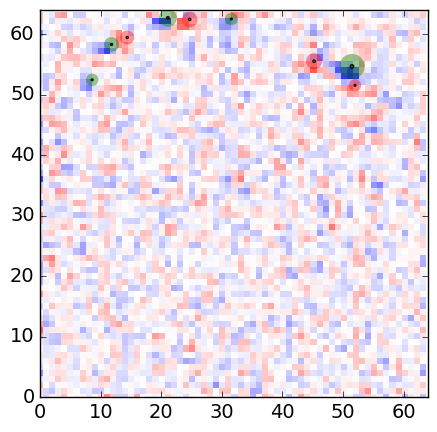

false

In [46]:
PyPlot.ion()
#################
font1 = Dict("family"=>"DejaVu Serif",
    "color"=>"black",
    "weight"=>"normal",
    "size"=>20)
seg=round(t/7022, 4)
titulo="$seg s"
figure(figsize=(5,5))
PyPlot.xlim(0,64)
PyPlot.ylim(0,64)

otraimagen=imshow(CSDEjemplo, cmap="bwr", origin="lower", vmin=-50, vmax=50, interpolation="nearest")
#cb=colorbar(otraimagen)
#cb=colorbar(otraimagen, ticks=[-150, +150],fraction=0.046, pad=0.04, use_gridspace='True')
#cb=colorbar(otraimagen, ticks=[-150, +150], use_gridspec="True")
#farofa=cb[:set_ticklabels]([{"Sink"}, {"Source"}])
#xlabel("furufu", fontdict=font1)

scatter(xxpos,yypos, s=valorpos, alpha=0.4, c="r", edgecolors="none")
scatter(xxneg, yyneg, s=abs(valorneg), alpha=0.4, c="g", edgecolors="none")
scatter(xxpos,yypos, s=0.02*valorpos, alpha=0.9, c="yellow", edgecolors="black")
scatter(xxneg, yyneg,s=0.02*abs(valorneg), alpha=0.9, c="green", edgecolors="black")

tick_params(axis="both", labelsize=14)

#title(titulo, fontdict=font1)
 #tight_layout()
savefig("CSDCM-discos-$t.svg", dpi=90)
PyPlot.close_queued_figs()